In [88]:
import pandas as pd

dec_merged = pd.read_csv('../DATASET/obs_est_merged/dec_merged.csv')

In [89]:
dec_merged

,lat,lon,year,month,precip_est,precip_obs,bias_dec
0,45.0,-20.0,1982,1,114.242190,158.107760,-43.865570
1,45.0,-19.0,1982,1,109.765625,138.565060,-28.799435
2,45.0,-18.0,1982,1,106.218750,122.867584,-16.648834
3,45.0,-17.0,1982,1,105.335940,109.741210,-4.405270
4,45.0,-16.0,1982,1,103.375000,106.399536,-3.024536
...,...,...,...,...,...,...,...
230251,20.0,16.0,2017,6,0.351885,3.776550,-3.424665
230252,20.0,17.0,2017,6,0.426104,3.719330,-3.293226
230253,20.0,18.0,2017,6,1.090166,3.147125,-2.056959
230254,20.0,19.0,2017,6,1.437823,0.000000,1.437823


In [90]:
dec_merged = dec_merged.drop(columns=['year', 'bias_dec'])

In [91]:
dec_average= dec_merged.groupby(['month', 'lat', 'lon']).agg({'precip_est': 'mean', 'precip_obs': 'mean'}).reset_index()
dec_average['is_train'] = dec_average['month'].apply(lambda x: x in [1, 2, 3])  # temporary splitting

In [92]:
dec_average

,month,lat,lon,precip_est,precip_obs,is_train
0,1,20.0,-20.0,2.776387,2.457407,True
1,1,20.0,-19.0,2.335524,2.952894,True
2,1,20.0,-18.0,1.751973,2.349642,True
3,1,20.0,-17.0,1.510762,2.645599,True
4,1,20.0,-16.0,1.556878,3.575113,True
...,...,...,...,...,...,...
6391,6,45.0,16.0,108.792222,85.306486,False
6392,6,45.0,17.0,97.997190,82.352003,False
6393,6,45.0,18.0,90.076890,72.088453,False
6394,6,45.0,19.0,82.176879,62.483258,False


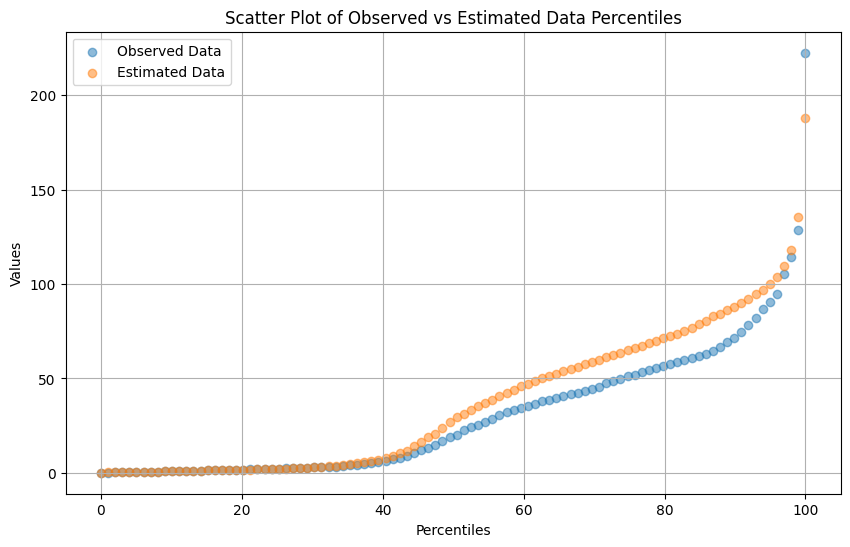

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = dec_average[dec_average['is_train'] == True]['precip_obs']  # ref_data_ast
estimated_data = dec_average[dec_average['is_train'] == True]['precip_est']  # estimated_past

# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Estimated Data')

plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an over estimation generally!!

In [105]:
import pandas as pd
import numpy as np
from scipy.stats import percentileofscore

def eQM_porcentual_delta(ref_dataset, model_present, model_future):
    """
    Remove biases for each quantile value by calculating the difference between
    ref_dataset and model_present at each percentile as a systematic bias (delta)
    and then apply this same delta to model_future at the corresponding percentile.
    """
   
    model_present_corrected = np.zeros(model_present.size)  
    model_future_corrected = np.zeros(model_future.size)

    # Ensure model values are never zero to avoid division by zero
    epsilon = 1e-10  # A small number to prevent division by zero
    model_present_safe = np.where(model_present == 0, epsilon, model_present)
    model_future_safe = np.where(model_future == 0, epsilon, model_future)

    for ival, model_value in enumerate(model_present_safe):
        percentile = percentileofscore(model_present_safe, model_value)
        percentile_ref = np.percentile(ref_dataset, percentile)
        dif = (percentile_ref - model_value) / model_value
        model_present_corrected[ival] = model_value * (1 + dif)
        model_future_corrected[ival] = model_future_safe[ival] * (1 + dif)
            
    return model_present_corrected, model_future_corrected

# Applying the correction
dec_average['corrected_precip_est'] = 0  # Initialize the column for corrected estimates

# Separate the datasets
is_train = dec_average['is_train']
ref_dataset = dec_average[is_train]['precip_obs']
model_present = dec_average[is_train]['precip_est']
model_future = dec_average[~is_train]['precip_est']

model_present_corrected, model_future_corrected = eQM_porcentual_delta(ref_dataset, model_present, model_future)

# Correct the DataFrame
dec_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected
dec_average.loc[~is_train, 'corrected_precip_est'] = model_future_corrected

test_data = dec_average[dec_average['is_train'] == False]
dec_average.loc[test_data.index, 'RMSE'] = np.sqrt((test_data['corrected_precip_est'] - test_data['precip_obs'])**2)

C:\Users\DataScience\AppData\Local\Temp\ipykernel_54956\3556413741.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 2.74734587  2.46106151  1.82060648 ... 42.46362033 39.04095144
 33.22162584]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dec_average.loc[is_train, 'corrected_precip_est'] = model_present_corrected


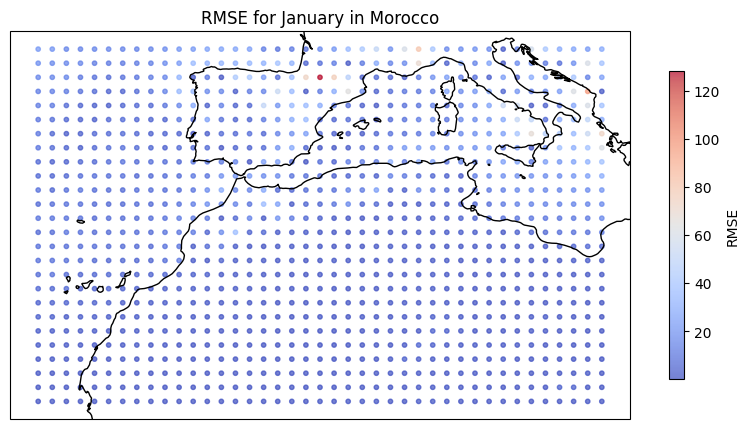

In [112]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd
import seaborn as sns

# Load your data into a DataFrame.
df = dec_average

# Filter the DataFrame for January and is_train == False.
january_test_df = df[(df['month'] == 4) & (df['is_train'] == False)]

# Create a scatter plot using plt.scatter for the lat/lon with the color intensity based on the RMSE.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

# You might want to adjust the extent to frame Morocco properly
# ax.set_extent([left_longitude, right_longitude, bottom_latitude, top_latitude])

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', 
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

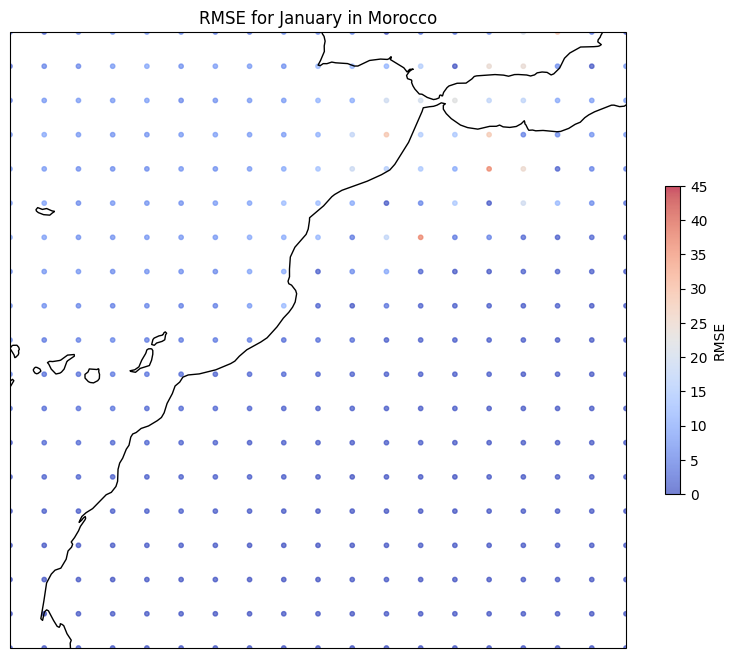

In [111]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

# Load your data into a DataFrame.
df = dec_average  # Make sure 'dec_average' is defined and contains your data.

# Filter the DataFrame for January and is_train == False.
january_test_df = df[(df['month'] == 4) & (df['is_train'] == False)]

# Start by setting up the figure and axes with the desired size and projection.
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the extent of the map to frame Morocco properly.
# This should come before plotting the scatter plot to avoid any overlay issues.
ax.set_extent([-18, 0, 20, 38])

# Add the coastlines to the map for reference.
ax.coastlines()

scatter = ax.scatter(january_test_df['lon'], january_test_df['lat'], 
                     c=january_test_df['RMSE'], cmap='coolwarm', vmin=0, vmax=45,
                     s=10, alpha=0.7, transform=ccrs.PlateCarree())

plt.colorbar(scatter, shrink=0.5, label='RMSE')
plt.title('RMSE for January in Morocco')
plt.show()

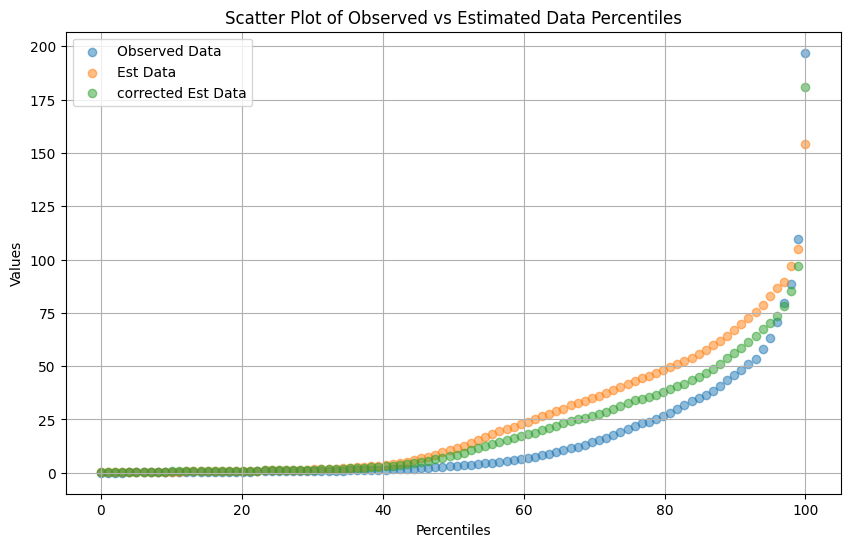

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# Let's assume we have two numpy arrays of data: observed and estimated
# For the sake of example, I'll generate some random data to represent this
# np.random.seed(42)
observed_data = dec_average[dec_average['is_train'] == False]['precip_obs']
estimated_data = dec_average[dec_average['is_train'] == False]['precip_est']
corrected_estimated_data = dec_average[dec_average['is_train'] == False]['corrected_precip_est']


# Calculate the percentiles
percentiles = np.linspace(0, 100, 100)  # 100 percentiles from 0 to 100
observed_percentiles = np.percentile(observed_data, percentiles)
estimated_percentiles = np.percentile(estimated_data, percentiles)
corrected_estimated_percentiles = np.percentile(corrected_estimated_data, percentiles)

plt.figure(figsize=(10, 6))
plt.scatter(percentiles, observed_percentiles, alpha=0.5, label='Observed Data')
plt.scatter(percentiles, estimated_percentiles, alpha=0.5, label='Est Data')
plt.scatter(percentiles, corrected_estimated_percentiles, alpha=0.5, label='corrected Est Data')


plt.title('Scatter Plot of Observed vs Estimated Data Percentiles')
plt.xlabel('Percentiles')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

## We have an under isitimation generally!!

In [51]:
dec_average

,month,lat,lon,precip_est,precip_obs,is_train,corrected_precip_est,RMSE
0,1,20.0,-20.0,2.776387,2.457407,True,2.457407,NaN
1,1,20.0,-19.0,2.335524,2.952894,True,2.952894,NaN
2,1,20.0,-18.0,1.751973,2.349642,True,2.349642,NaN
3,1,20.0,-17.0,1.510762,2.645599,True,2.645599,NaN
4,1,20.0,-16.0,1.556878,3.575113,True,3.575113,NaN
...,...,...,...,...,...,...,...,...
6391,6,45.0,16.0,108.792222,85.306486,True,85.306486,NaN
6392,6,45.0,17.0,97.997190,82.352003,True,82.352003,NaN
6393,6,45.0,18.0,90.076890,72.088453,True,72.088453,NaN
6394,6,45.0,19.0,82.176879,62.483258,True,62.483258,NaN
